In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# 加载数据
with open('R_ET_1_ET_2_ET_3_0.pkl', 'rb') as file:
    data = pickle.load(file)

In [2]:
# 提取 9x9 的 Fisher 矩阵
fisher_matrix_1 = data[1]
fisher_matrix_2 = data[2][0]
fisher_matrix_3 = data[2][1]

# 打印每个 Fisher 矩阵的形状和内容
print(f"Fisher 矩阵 1 (ET_1):\n{fisher_matrix_1}\n")
print(f"Fisher 矩阵 2 (ET_2):\n{fisher_matrix_2}\n")
print(f"Fisher 矩阵 3 (ET_3):\n{fisher_matrix_3}\n")

# 检查每个 Fisher 矩阵的形状是否符合预期
assert fisher_matrix_1.shape == (9, 9), "Fisher 矩阵 1 尺寸不匹配"
assert fisher_matrix_2.shape == (9, 9), "Fisher 矩阵 2 尺寸不匹配"
assert fisher_matrix_3.shape == (9, 9), "Fisher 矩阵 3 尺寸不匹配"

Fisher 矩阵 1 (ET_1):
[[ 4.88439419e+06  6.28884176e+05  3.94922216e+08  1.58546254e+04
   1.30809358e+06 -5.33741930e+09 -7.25350220e+03 -5.28083064e+09
  -5.14043623e+05]
 [ 6.28884176e+05  1.02318971e+06 -1.50416305e+08 -4.58361328e+04
   2.75853785e+05 -1.52930408e+09  2.08454070e+04 -1.55837793e+09
   9.59233631e+03]
 [ 3.94922216e+08 -1.50416305e+08  7.52393549e+10 -3.27933212e+04
   8.27921534e+07 -2.60342498e+11  2.35227745e+04 -2.48092420e+11
  -5.81903462e+07]
 [ 1.58546254e+04 -4.58361328e+04 -3.27933212e+04  4.80865364e+05
   2.96859771e+01 -4.78015116e+05 -2.16041829e+05 -5.20066374e+05
   6.72039678e+00]
 [ 1.30809358e+06  2.75853785e+05  8.27921534e+07  2.96859771e+01
   3.62576635e+05 -1.52859861e+09 -6.30912622e+00 -1.51766899e+09
  -1.29054804e+05]
 [-5.33741930e+09 -1.52930408e+09 -2.60342498e+11 -4.78015116e+05
  -1.52859861e+09  2.74473998e+13  9.71786021e+04  2.77393538e+13
   1.07437624e+09]
 [-7.25350220e+03  2.08454070e+04  2.35227745e+04 -2.16041829e+05
  -6.309

In [3]:
def check_fisher_matrix(matrix, name):
    print(f"\n检查 {name}:")
    print(f"矩阵形状: {matrix.shape}")
    print(f"矩阵条件数: {np.linalg.cond(matrix)}")
    print(f"是否对称: {np.allclose(matrix, matrix.T)}")

# 检查每个 Fisher 矩阵
check_fisher_matrix(fisher_matrix_1, "Fisher 矩阵 1 (ET_1)")
check_fisher_matrix(fisher_matrix_2, "Fisher 矩阵 2 (ET_2)")
check_fisher_matrix(fisher_matrix_3, "Fisher 矩阵 3 (ET_3)")


检查 Fisher 矩阵 1 (ET_1):
矩阵形状: (9, 9)
矩阵条件数: 49331252765552.74
是否对称: True

检查 Fisher 矩阵 2 (ET_2):
矩阵形状: (9, 9)
矩阵条件数: 2.6226194699865115e+21
是否对称: True

检查 Fisher 矩阵 3 (ET_3):
矩阵形状: (9, 9)
矩阵条件数: 49331252765552.74
是否对称: True


In [4]:
#参数名列表（去掉 Injection Number 和 Initial Phase）
PARAM_NAMES = [
    "Ra", "Dec", "Mass1", "Mass2", 
    "Inclination", "Polarization", 
    "Luminosity Distance"
]

In [5]:
def get_dynamic_epsilon(matrix):
    """根据矩阵的条件数和特征值标准差，动态生成正则化参数 epsilon。"""
    cond_number = np.linalg.cond(matrix)
    eigvals = np.linalg.eigvals(matrix)
    eigval_std = np.std(eigvals)

    epsilon = (
        1e-2 if cond_number > 1e20 or eigval_std > 1e2 else
        1e-3 if cond_number > 1e16 or eigval_std > 1e1 else
        1e-4 if cond_number > 1e12 else
        1e-6
    )
    print(f"条件数: {cond_number}, 特征值标准差: {eigval_std}, 正则化参数: {epsilon}")
    return epsilon

In [6]:
def ensure_positive_definite(matrix):
    """确保矩阵为正定矩阵，并返回处理后的矩阵。"""
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals_clipped = np.clip(eigvals, 1e-8, None)  # 将特征值剪裁至最小值 1e-8
    return eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

In [7]:
def regularize_matrix(matrix):
    """正则化 Fisher 矩阵，确保其对称且可逆。"""
    epsilon = get_dynamic_epsilon(matrix)
    matrix_sym = (matrix + matrix.T) / 2  # 确保矩阵对称
    return ensure_positive_definite(matrix_sym + epsilon * np.eye(matrix.shape[0]))

In [8]:
def compute_covariance(fisher_matrix):
    """根据 Fisher 矩阵计算协方差矩阵，只保留需要的参数部分。"""
    # 只提取我们关心的 7 个参数对应的子矩阵
    fisher_submatrix = fisher_matrix[:7, :7]
    reg_matrix = regularize_matrix(fisher_submatrix)
    covariance_matrix = np.linalg.pinv(reg_matrix)
    print(f"协方差矩阵:\n{covariance_matrix}")
    return covariance_matrix

def compute_uncertainties(cov_matrix):
    """从协方差矩阵中提取每个参数的不确定度。"""
    uncertainties = np.sqrt(np.diag(cov_matrix))
    print(f"不确定度: {uncertainties}")
    return uncertainties

In [9]:
# 初始化存储不确定度结果的字典
uncertainty_results = {}  # 这行非常关键，确保字典已定义

# 遍历每个 Fisher 矩阵并计算不确定度
for i, fisher_matrix in enumerate([fisher_matrix_1, fisher_matrix_2, fisher_matrix_3], start=1):
    print(f"\n处理 Fisher 矩阵 {i}...")
    
    # 计算协方差矩阵
    cov_matrix = compute_covariance(fisher_matrix)  # 删除多余参数
    
    # 计算不确定度
    uncertainties = np.sqrt(np.diag(cov_matrix))  # 提取对角线元素并计算不确定度
    
    # 将结果存入字典
    detector_name = f"ET_{i}"
    uncertainty_results[detector_name] = uncertainties

# 查看不确定度结果
print("\n不确定度结果:")
for detector, uncertainties in uncertainty_results.items():
    print(f"{detector}: {uncertainties}")


处理 Fisher 矩阵 1...
条件数: 21331419872879.277, 特征值标准差: 9601244843554.428, 正则化参数: 0.01
协方差矩阵:
[[ 4.12234757e-02  2.35823581e-02  1.89464425e-05  9.01572714e-04
  -1.71064358e-01 -1.69113873e-08  2.32512089e-06]
 [ 2.35823592e-02  1.57412308e-02  1.93595457e-05  7.29695703e-04
  -1.01503611e-01 -6.40315639e-09 -1.79277012e-06]
 [ 1.89464466e-05  1.93595475e-05  4.09861583e-08  1.22434333e-06
  -9.24233927e-05  4.53669395e-12 -1.07552338e-08]
 [ 9.01572818e-04  7.29695738e-04  1.22434329e-06  4.31558784e-05
  -4.08765497e-03 -5.88708188e-11  2.02908858e-06]
 [-1.71064360e-01 -1.01503608e-01 -9.24233764e-05 -4.08765458e-03
   7.15768409e-01  6.50994806e-08 -4.59177934e-06]
 [-1.69113857e-08 -6.40315504e-09  4.53669636e-12 -5.88707419e-11
   6.50994733e-08  5.96232744e-14 -5.46864475e-12]
 [ 2.32511938e-06 -1.79277104e-06 -1.07552348e-08  2.02908854e-06
  -4.59177297e-06 -5.46864422e-12  5.06834725e-06]]

处理 Fisher 矩阵 2...
条件数: 1.0954389552853506e+20, 特征值标准差: 7499387199625.0625, 正则化参数: 0.01
协方

In [10]:
# 定义参数名
PARAM_NAMES = [
    "Ra", "Dec", "Mass1", "Mass2", 
    "Inclination", "Polarization", 
    "Luminosity Distance"
]

# 创建 DataFrame 存储不确定度
df = pd.DataFrame(uncertainty_results, index=PARAM_NAMES)
df.index.name = "Parameter"

# 打印 DataFrame 结果
print("\n不确定度结果 DataFrame:")
display(df)


不确定度结果 DataFrame:


,ET_1,ET_2,ET_3
Parameter,,,
Ra,2.030357e-01,1.268195e-03,2.030357e-01
Dec,1.254641e-01,7.457603e-04,1.254641e-01
Mass1,2.024504e-04,1.956663e-04,2.024504e-04
Mass2,6.569313e-03,4.036610e-03,6.569313e-03
Inclination,8.460310e-01,3.951222e-04,8.460310e-01
Polarization,2.441788e-07,8.267307e-07,2.441788e-07
Luminosity Distance,2.251299e-03,5.209958e-03,2.251299e-03


In [11]:
# 保存结果为 CSV 文件
output_file = "fisher_uncertainties.csv"
df.to_csv(output_file)

print(f"结果已保存至 {output_file}")


结果已保存至 fisher_uncertainties.csv


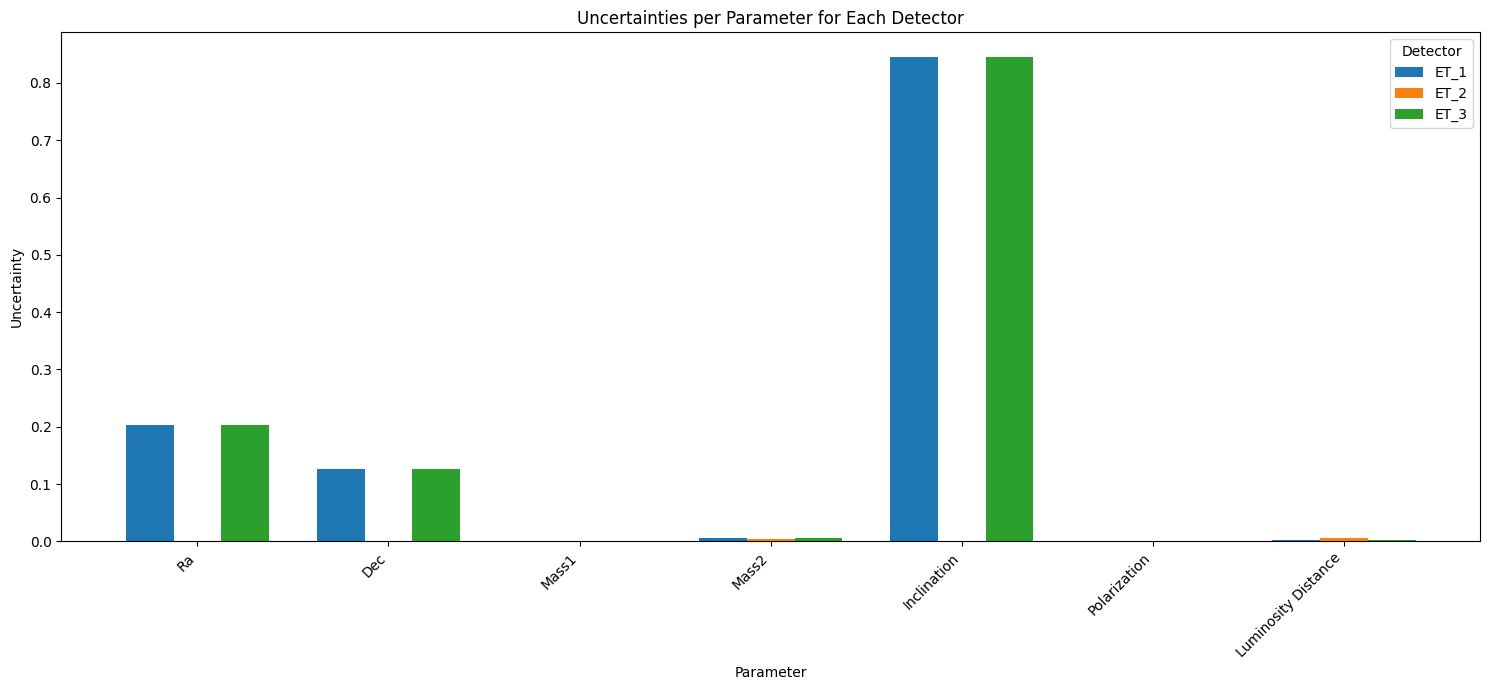

In [12]:
# 可视化不确定度结果
bar_width = 0.25
x = np.arange(len(PARAM_NAMES))

plt.figure(figsize=(15, 7))

# 绘制每个检测器的柱状图
for i, detector in enumerate(df.columns):
    plt.bar(x + i * bar_width, df[detector], width=bar_width, label=detector)

# 设置坐标轴和标题
plt.xticks(x + bar_width, PARAM_NAMES, rotation=45, ha='right')
plt.xlabel('Parameter')
plt.ylabel('Uncertainty')
plt.title('Uncertainties per Parameter for Each Detector')
plt.legend(title='Detector')

plt.tight_layout()
plt.show()